### 변이형 오토인코더

In [11]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

input_dim = 784
hidden_dim = 200
latent_dim = 20
epochs = 30
learning_rate = 3e-4
batch_size = 32

class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_lgvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        lgvar = self.linear_lgvar(h)
        sigma = torch.exp(0.5 * lgvar)
        return mu, sigma

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        x_hat = F.sigmoid(h)
        return x_hat


def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def get_loss(self, x):
        mu, sigma = self.encoder(x)
        z = reparameterize(mu, sigma)
        x_hat = self.decoder(z)

        batc_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma ** 2) - mu ** 2 - sigma ** 2)
        return (L1 + L2) / batc_size

In [12]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(torch.flatten)
])

dataset = datasets.MNIST(
    root='./data',
    train=True,
    transform=transform,
    download=True)

dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True
)

model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
losses = []
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1
    loss_avg = loss_sum / cnt
    losses.append(loss_avg)
    print(f'Epoch {epoch}, Loss: {loss_avg}')


Epoch 0, Loss: 54.168777616373696
Epoch 1, Loss: 45.35807796020508
Epoch 2, Loss: 43.28124707845052
Epoch 3, Loss: 42.093978110758464
Epoch 4, Loss: 41.391632672119144
Epoch 5, Loss: 40.889833951822915
Epoch 6, Loss: 40.486945509847004
Epoch 7, Loss: 40.241278619384765
Epoch 8, Loss: 40.01455666503906
Epoch 9, Loss: 39.85722236124675
Epoch 10, Loss: 39.72839715983073
Epoch 11, Loss: 39.59968305460612
Epoch 12, Loss: 39.4797201751709
Epoch 13, Loss: 39.416857275390626
Epoch 14, Loss: 39.35222447713216
Epoch 15, Loss: 39.21873652750651
Epoch 16, Loss: 39.16360018717448
Epoch 17, Loss: 39.0750011698405
Epoch 18, Loss: 39.03320036417643
Epoch 19, Loss: 39.00167992553711
Epoch 20, Loss: 38.925810087076826
Epoch 21, Loss: 38.88215634969075
Epoch 22, Loss: 38.803995967610675
Epoch 23, Loss: 38.78726780802409
Epoch 24, Loss: 38.74546151123047
Epoch 25, Loss: 38.67465586954753
Epoch 26, Loss: 38.682552864583336
Epoch 27, Loss: 38.66684353637695
Epoch 28, Loss: 38.58283792317708
Epoch 29, Loss: 

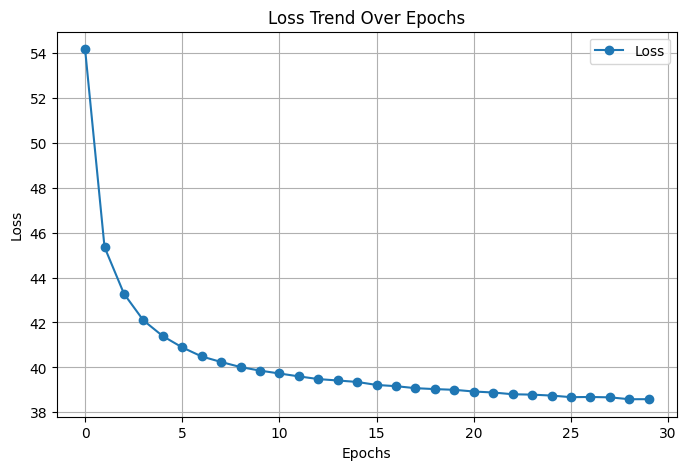

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(epochs), losses, marker='o', label='Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.grid(True)
plt.legend()
plt.show()

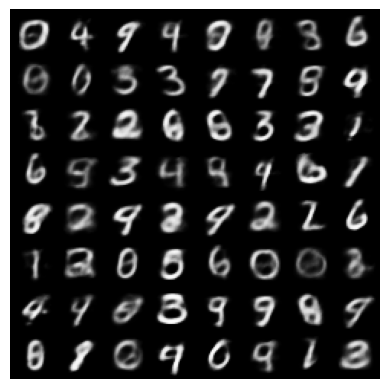

In [19]:
with torch.no_grad():
    simple_size = 64
    z = torch.randn(simple_size, latent_dim)
    x = model.decoder(z)
    generated_images = x.view(simple_size,  1, 28, 28)

grid_img = torchvision.utils.make_grid(
    generated_images,
    nrow=8,
    padding=2,
    normalize=True)

plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()